# Analiza przeżycia na przykładzie zbioru colon z pakietu survival 
### Cel projektu:
Projekt ma na celu zaproponowanie prostego schematu analizy przeżycia, w którym badać będziemy efektywność adiuwantowych chemioterapii w leczeniu raka jelita grubego na podstawie zbioru danych *colon* z pakietu survival dedykowanego dla języka R. 
W ramach projektu zaproponowane zostaną modele:
1. Parametryczny
2. Nieparametryczny
3. Semiparametryczny
<br><br>
### Analiza przeżycia
Analiza przeżycia skupia się na modelowaniu czasu do zaistnienia jakiegoś zdarzenia, przykładowo takim zdarzeniem może być śmierć pacjenta lub nawrot choroby. Najczęsciej dane opierają się na badaniu prowadzonym przez jakiś określony czas na określonej próbie. Obserwację zdarzenia dla jednostki podczas okresu badania określamy jako failure, a brak obserwacji jako censoring. <br>
W analizie przeżycia chcemy określić wpływ zmiennych na prawdopodobieństwo zaistnienia danego zdarzenia. Przykładowo możemy chcieć sprawdzić, czy terapia jest efektywna w leczeniu choroby.
<br><br>
### Opis danych
Jak już zostało wspomniane do projektu użyliśmy zbioru danych *colon* z pakietu survival. Zbiór stworzony został na podstawie jednej z pierwszych udanych prób leczenia raka jelita grubego poprzez adiuwantową chemioterapię. 
 <br>
Cały zbiór składa się z 16 kolumn:
-  id: id
-  study: 1 for all patients
-  rx: Treatment - Obs(ervation), Lev(amisole), Lev(amisole)+5-FU
-  sex: 1=male
-  age: in years
-  obstruct: obstruction of colon by tumour
-  perfor: perforation of colon
-  adhere: adherence to nearby organs
-  nodes: number of lymph nodes with detectable cancer
-  time: days until event or censoring
-  status: censoring status
-  differ: differentiation of tumour (1=well, 2=moderate, 3=poor)
-  extent: Extent of local spread (1=submucosa, 2=muscle, 3=serosa, 4=contiguous structures)
-  surg: time from surgery to registration (0=short, 1=long)
-  node4: more than 4 positive lymph nodes
-  etype: event type: 1=recurrence,2=death


Aby nie komplikować zbytnio analizy, spośród wyżej wymieniobych wybraliśmy 6 zmiennych do naszej analizy, nie wliczając oczywistych zmiennych określających czas i status. Są to:
- rx
- sex
- age
- obstruct
- adhere
- differ
<br> <br> Zmienne te zostały wybrane arbitralnie kierując się naszą niewielką wiedzą na temat raka jelita grubego oraz dokumentacją pakietu survival, która wskazuje na istniejące problemy ze zmienną node4.

Analizę zaczynamy od załadowania potrzebnych bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as lfl
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Eksploracja danych

Analizę rozpoczynamy od krótkiej eksploracji naszego zbioru danych. Jak już zostało wspomniane, do analizy wybraliśmy zmienne: 'time', 'status', 'rx', 'sex', 'age', 'obstruct', 'adhere', 'differ'. 

Ponieważ chcemy badać wpływ terapi Lev(amisole) + 5-FU, wyrzucamy zmienną określającą terapię Lev(amisole), czyli 'rx' = 2

In [2]:
colon = pd.read_csv('../data/colon.csv')

In [3]:
colon = colon[['time', 'status', 'rx', 'sex', 'age', 'obstruct', 'adhere', 'differ']]

In [4]:
# Wyrzucamy Lev(amisole)
colon = colon[colon['rx'] != 2]

Na zbiór danych składa się 583 rekordów

In [5]:
len(colon)

583

In [6]:
colon.head()

,time,status,rx,sex,age,obstruct,adhere,differ
0,8,1,3,0,32,0,0,3
1,9,1,3,1,55,1,0,3
2,19,1,1,1,59,1,0,2
4,23,0,3,0,52,0,0,3
5,24,0,1,1,72,1,0,3


In [7]:
colon.dropna(inplace=True)
len(colon)

583

## Analiza nieparametryczna

W analiznie nieparametrycznej wyciągamy wnioski bezpośrednio z naszych danych bez przyjmowania żadnych dodatkowych założeń. Jej celem jest uzyskanie obserwowalnej krzywej przeżycia (survival curve) oraz obserwowalnej funkcji hazardu. Ponadto dla zmiennych kategorialnych możemy wizualnie sprawdzić wpływ zmiennej na krzywą przeżycia. 

Krzywą przeżycia wyznaczymy stosując estymator Kaplana-Meiera, natomiast funkcję hazardu wyznaczymy przy pomocy estymatora Nelsona-Aalena.

Kolejno przejdziemy przez następujące punkty:
- analiza korelacji zmiennych
- estymacja krzywej przeżycia
- estymacja funkcji hazardu
- wizualna ocena wpływu zmiennych na krzywą przeżycia oraz testy log-rank

### Analiza korelacji

In [8]:
# Tworzymy dataframe korelacji zmiennych
correlations = colon.corr()['time']
correlations_df = pd.DataFrame(correlations)
correlations_df.drop(['status', 'time'], inplace=True)
correlations_df.reset_index(inplace=True)
correlations_df.columns = ['zmienna', 'korelacja z czasem przeżycia']

<Axes: xlabel='korelacja z czasem przeżycia', ylabel='zmienna'>

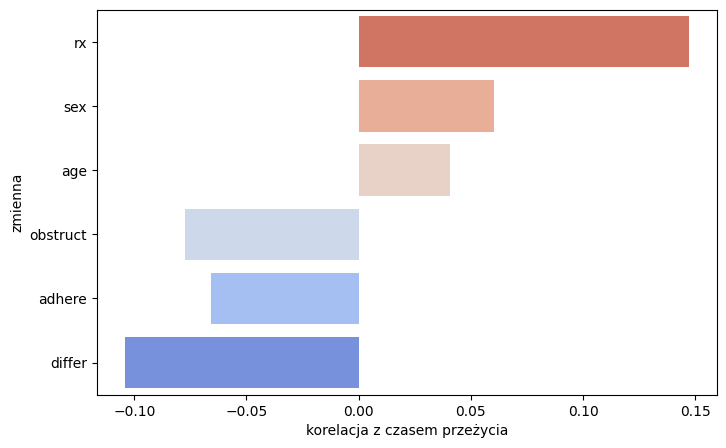

In [9]:
# Wizualizacja
plt.figure(figsize=(8, 5))
sns.barplot(
    data=correlations_df,    
    y='zmienna',
    x='korelacja z czasem przeżycia',
    palette='coolwarm_r', 
    orient='h'
)

Z powyższego wykresu wynika, że najsilniej skorelowaną z czasem przeżycia zmienną jest zmienna rx oznaczająca terapię. Zmienna ta jest pozytywnie skorelowana, co oznacza, że jej większa wartość idzie w parze z wydłużonym czasem przeżycia. Należy zatem zaznaczyć, że rx = 0 oznacza zwykłą obserwację pacjenta, natomiast rx = 3 oznacza terapię Lev(amisole) + 5-FU.

Obserwujemy również dosyć silną ujemną korelację zmiennej differ z czasem przeżycia. Zmienna differ określa poziom różnicy komórek rakowych ze zdrowymi komórkami, im wyższy poziom, tym gorzej.

### Krzywa przeżycia

In [10]:
T = colon['time']
E = colon['status']

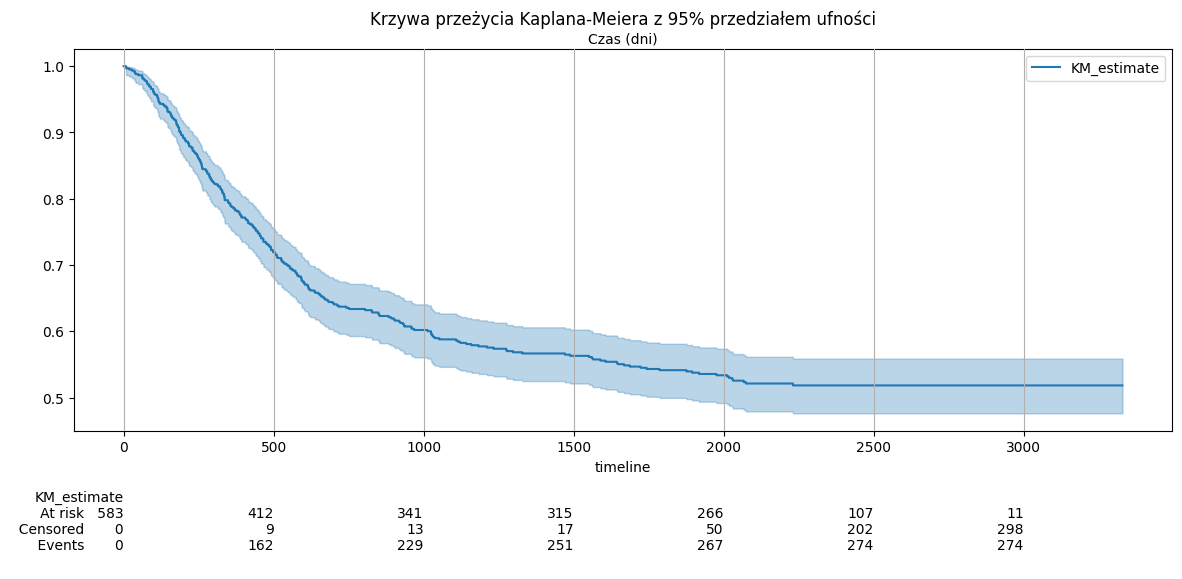

In [11]:
# Krzywa przeżycia - Kaplan-Meier
from lifelines.plotting import add_at_risk_counts

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf = lfl.KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, alpha=0.05)
kmf.plot(ax=ax, ci_show=True, ci_alpha=0.3)
add_at_risk_counts(kmf, ax=ax)

plt.title('Krzywa przeżycia Kaplana-Meiera z 95% przedziałem ufności')
plt.xlabel('Czas (dni)')
plt.ylabel('Prawdopodobieństwo przeżycia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
### Tabela przeżycia Kaplana-Meiera
print("\nTabela przeżycia Kaplana-Meiera")

### Tworzenie tabeli z wynikami
kmf_table = pd.DataFrame(kmf.survival_function_)
kmf_table.columns = ['Przeżycie']
kmf_table['Dolny przedz. ufności'] = kmf.confidence_interval_['KM_estimate_lower_0.95']
kmf_table['Górny przedz. ufności'] = kmf.confidence_interval_['KM_estimate_upper_0.95']
kmf_table['Skumulowana funkcja hazardu'] = -(np.log(kmf.survival_function_.values))
kmf_table['Skumulowana funkcja hazardu'][0] = 0 ### korekta wizualna
kmf_table['Zdarzenia'] = kmf.event_table['observed']
kmf_table['Cenzorowane'] = kmf.event_table['censored']
kmf_table['Narażeni na ryzyko'] = kmf.event_table['at_risk']


print("Fragment tabeli przeżycia (pierwsze 10 wierszy):")
display(kmf_table.head(10))
print("\nFragment tabeli przeżycia (ostatnie 10 wierszy):")
display(kmf_table.tail(10))



Tabela przeżycia Kaplana-Meiera
Fragment tabeli przeżycia (pierwsze 10 wierszy):


,Przeżycie,Dolny przedz. ufności,Górny przedz. ufności,Skumulowana funkcja hazardu,Zdarzenia,Cenzorowane,Narażeni na ryzyko
timeline,,,,,,,
0.0,1.000000,1.000000,1.000000,0.000000,0,0,583
8.0,0.998285,0.987887,0.999758,0.001717,1,0,583
9.0,0.996569,0.986354,0.999141,0.003436,1,0,582
19.0,0.994854,0.984131,0.998337,0.005159,1,0,581
23.0,0.994854,0.984131,0.998337,0.005159,0,1,580
24.0,0.994854,0.984131,0.998337,0.005159,0,1,579
28.0,0.993133,0.981808,0.997417,0.006891,1,0,578
35.0,0.991412,0.979491,0.996416,0.008625,1,0,577
38.0,0.989691,0.977197,0.995355,0.010363,1,0,576



Fragment tabeli przeżycia (ostatnie 10 wierszy):


,Przeżycie,Dolny przedz. ufności,Górny przedz. ufności,Skumulowana funkcja hazardu,Zdarzenia,Cenzorowane,Narażeni na ryzyko
timeline,,,,,,,
3024.0,0.518536,0.476379,0.558977,0.656746,0,1,10
3085.0,0.518536,0.476379,0.558977,0.656746,0,1,9
3087.0,0.518536,0.476379,0.558977,0.656746,0,1,8
3173.0,0.518536,0.476379,0.558977,0.656746,0,1,7
3185.0,0.518536,0.476379,0.558977,0.656746,0,1,6
3238.0,0.518536,0.476379,0.558977,0.656746,0,1,5
3308.0,0.518536,0.476379,0.558977,0.656746,0,1,4
3309.0,0.518536,0.476379,0.558977,0.656746,0,1,3
3325.0,0.518536,0.476379,0.558977,0.656746,0,1,2


### Funckja hazardu

In [13]:
## funkcja hazardu
naf = lfl.NelsonAalenFitter()
naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 583 total observations, 309 right-censored observations>

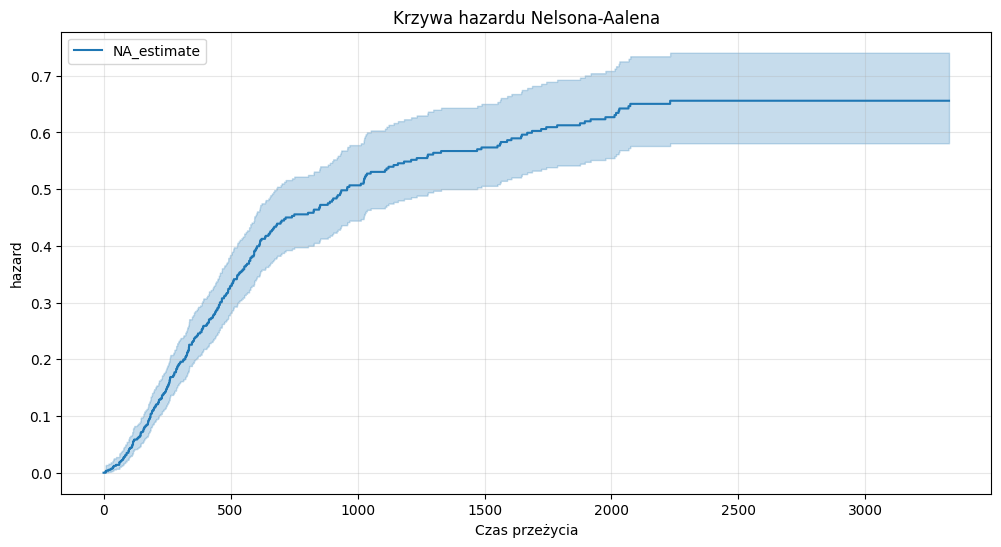

In [14]:
plt.figure(figsize=(12, 6))
naf.plot_cumulative_hazard()
plt.title('Krzywa hazardu Nelsona-Aalena')
plt.xlabel('Czas przeżycia')
plt.ylabel('hazard')
plt.grid(alpha = 0.3)
plt.show()

### Zmienne

#### 1. Zmienna określająca sposób leczenia - *rx*

In [15]:
colon['rx'].value_counts()

rx
1    294
3    289
Name: count, dtype: int64

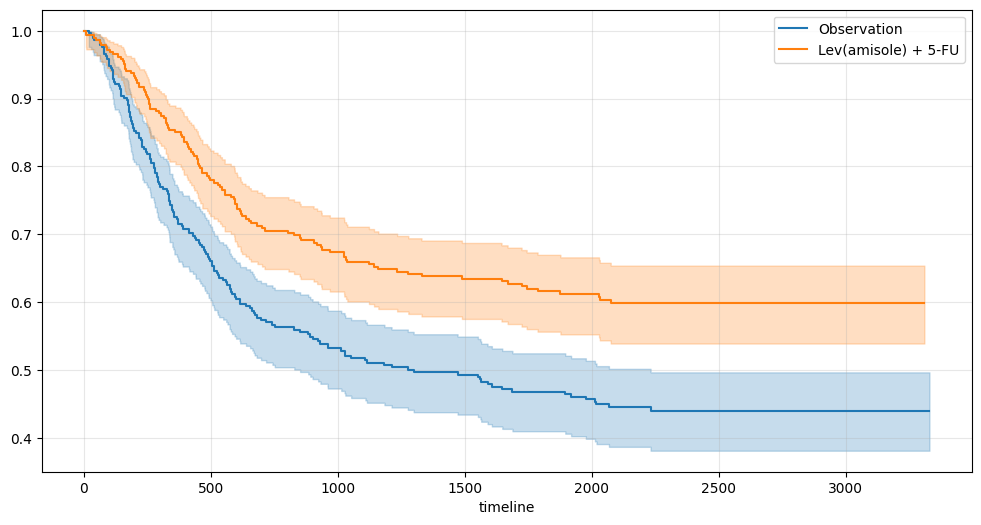

In [16]:
## K-M curve
rx1 = colon['rx'] == 1
rx3 = colon['rx'] == 3

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
kmf.fit(durations=T[rx1], event_observed=E[rx1], label='Observation')
kmf.plot(ax=ax)
kmf.fit(durations=T[rx3], event_observed=E[rx3], label='Lev(amisole) + 5-FU')
kmf.plot(ax=ax)
plt.grid(alpha = 0.3)

Krzywe narysowane z 95% przedziałem ufności. Krzywa dla pacjentów, którzy leczeni są terapią Lev(amisole) + 5-FU jest istotnie powyżej krzywej dla pacjentów tylko obserwowanych. Możemy wnioskować, że terapia zwiększa czas przeżycia.

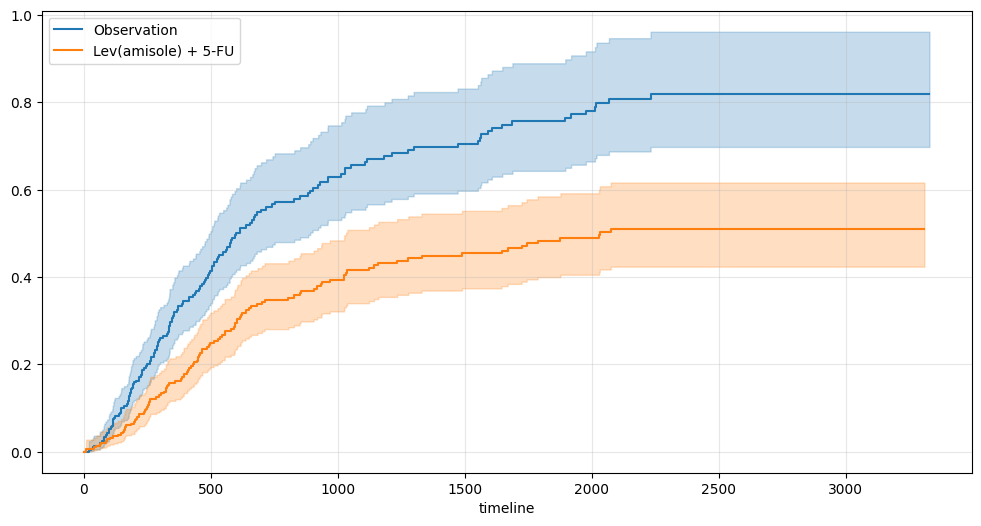

In [17]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(111)

naf.fit(durations=T[rx1], event_observed=E[rx1], label='Observation')
naf.plot(ax=ax)


naf.fit(durations=T[rx3], event_observed=E[rx3], label='Lev(amisole) + 5-FU')
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [18]:
## Log-Rank test

result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['rx'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          15.77 <0.005     13.77

Wyniki testu log-rank pozwalają nam odrzucić hipotezę zerową zakładającą brak różnicy rozkładów czasu przeżycia dla badanych kategorii. Możemy podejrzeważ, że zmienna rx okaże się istotna w modelach parametrycznych i semiparametrycznych.

#### 2. Zmienna określająca płeć - *sex*

In [19]:
colon['sex'].value_counts()

sex
1    299
0    284
Name: count, dtype: int64

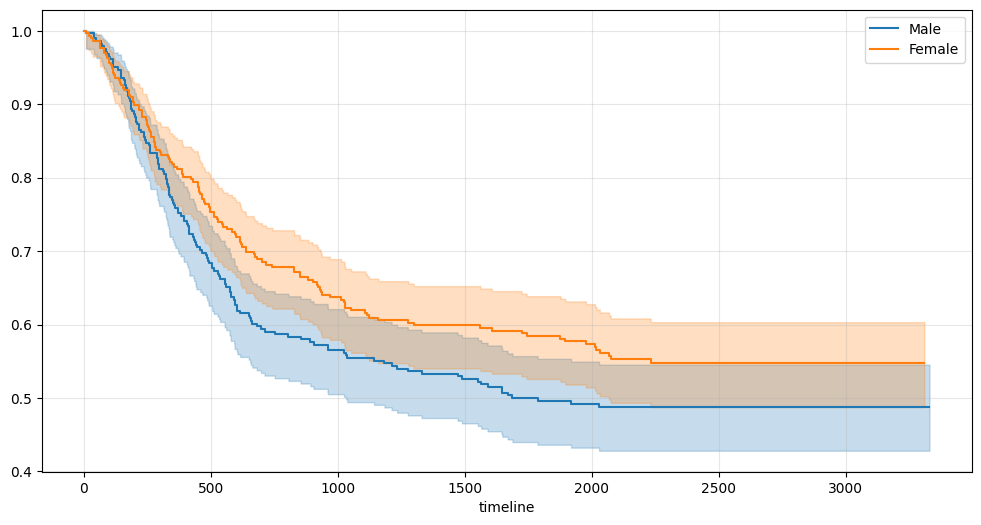

In [20]:
## Krzywa K-M
m = colon['sex'] == 0

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[m], event_observed=E[m], label='Male')
kmf.plot(ax=ax)

kmf.fit(durations=T[~m], event_observed=E[~m], label='Female')
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

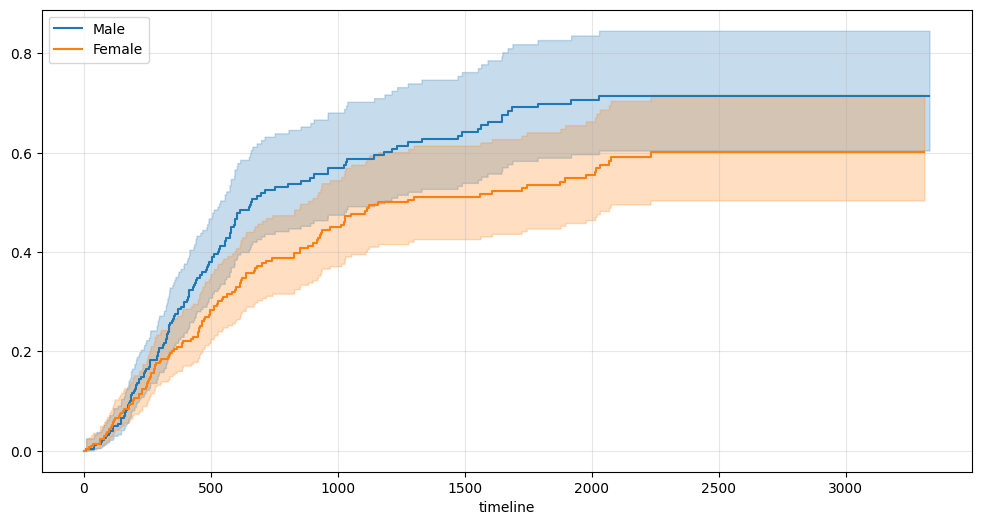

In [21]:
## Funkcja hazardu

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

naf.fit(durations=T[m], event_observed=E[m], label='Male')
naf.plot(ax=ax)

naf.fit(durations=T[~m], event_observed=E[~m], label='Female')
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [22]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['sex'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           2.97 0.08      3.56

Przy poziomie istotności 5% nie możemy odrzucić hipotezy zerowej.

#### 3. Zmienna obstruct

In [23]:
colon['obstruct'].value_counts()

obstruct
0    474
1    109
Name: count, dtype: int64

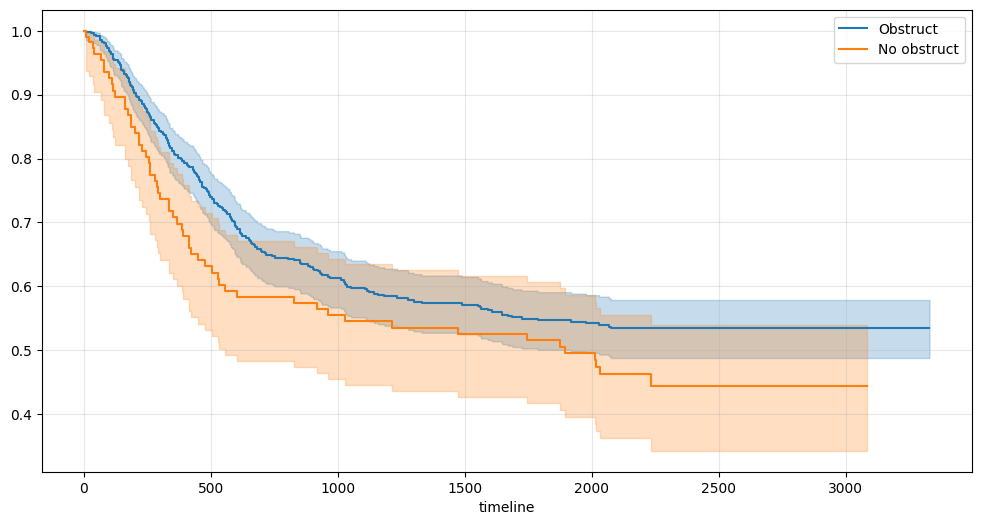

In [24]:
## Krzywa K-M
o = colon['obstruct'] == 0

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[o], event_observed=E[o], label='Obstruct')
kmf.plot(ax=ax)

kmf.fit(durations=T[~o], event_observed=E[~o], label='No obstruct')
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

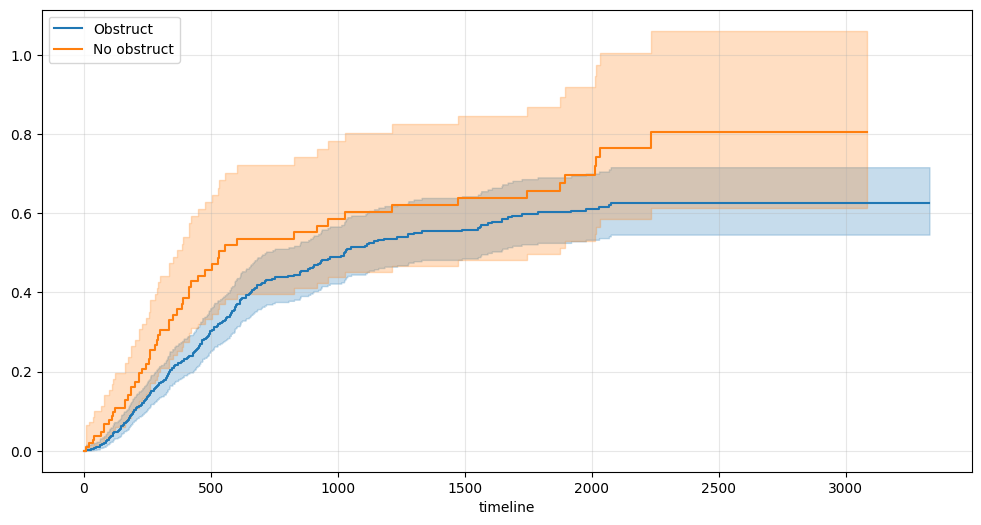

In [25]:
## Funkcja hazardu

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

naf.fit(durations=T[o], event_observed=E[o], label='Obstruct')
naf.plot(ax=ax)

naf.fit(durations=T[~o], event_observed=E[~o], label='No obstruct')
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [26]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['obstruct'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.13 0.08      3.70

#### 4. Zmienna adhere

In [27]:
colon['adhere'].value_counts()

adhere
0    500
1     83
Name: count, dtype: int64

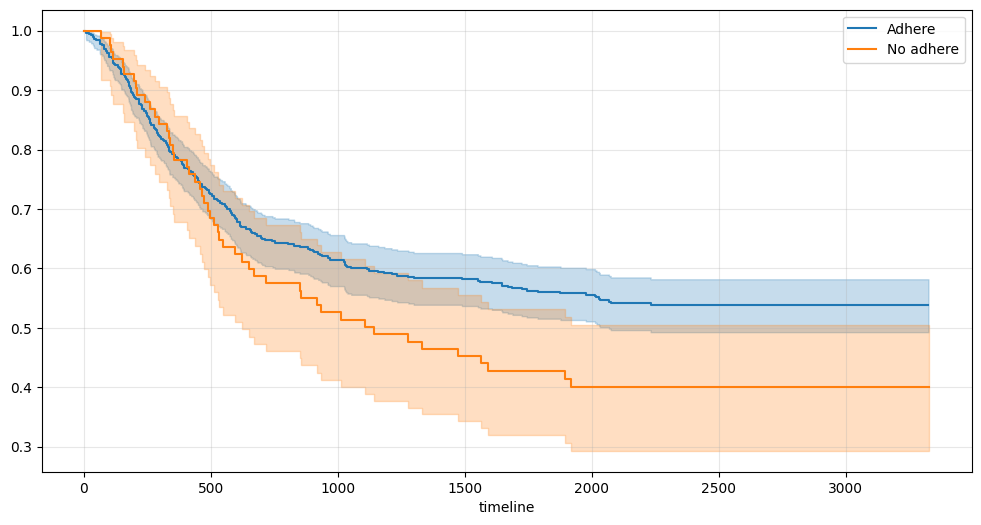

In [28]:
## Krzywa K-M
a = colon['adhere'] == 0

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[a], event_observed=E[a], label='Adhere')
kmf.plot(ax=ax)

kmf.fit(durations=T[~a], event_observed=E[~a], label='No adhere')
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

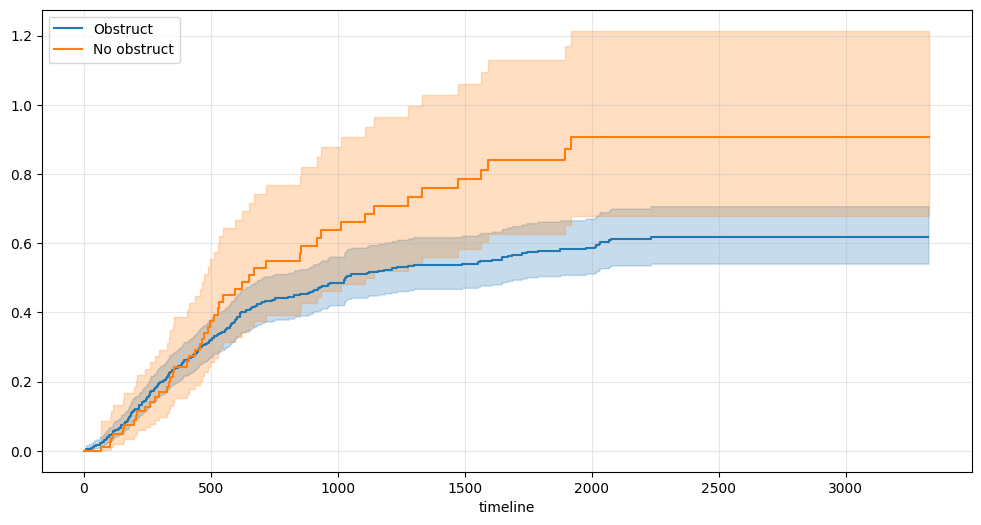

In [29]:
## Funkcja hazardu

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

naf.fit(durations=T[a], event_observed=E[a], label='Obstruct')
naf.plot(ax=ax)

naf.fit(durations=T[~a], event_observed=E[~a], label='No obstruct')
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [30]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['adhere'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           4.10 0.04      4.54

#### 5. Zmienna differ



In [31]:
colon['differ'].value_counts()

differ
2    427
3     93
1     63
Name: count, dtype: int64

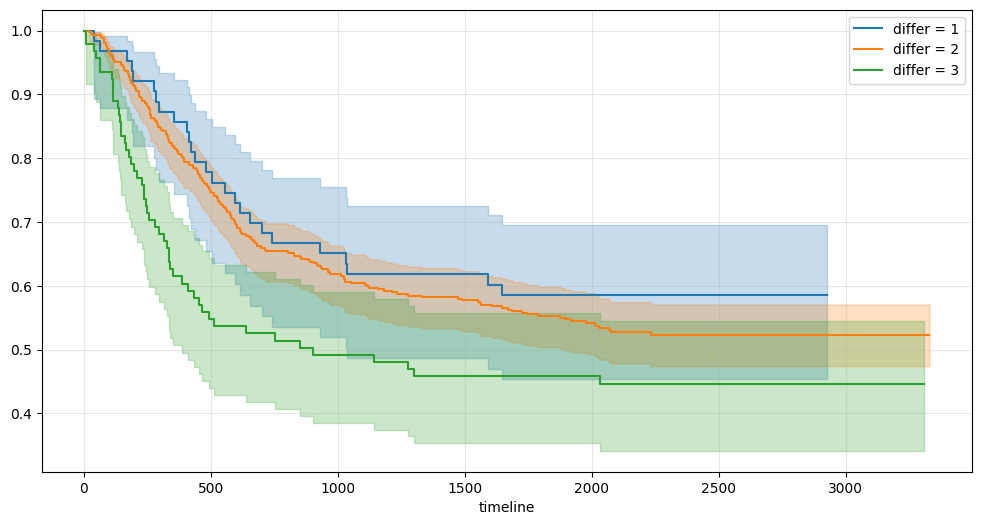

In [32]:
## Krzywa K-M
d1 = colon['differ'] == 1
d2 = colon['differ'] == 2
d3 = colon['differ'] == 3

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[d1], event_observed=E[d1], label='differ = 1')
kmf.plot(ax=ax)

kmf.fit(durations=T[d2], event_observed=E[d2], label='differ = 2')
kmf.plot(ax=ax)

kmf.fit(durations=T[d3], event_observed=E[d3], label='differ = 3')
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [33]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['adhere'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           4.10 0.04      4.54

## Analiza parametryczna

Analiza parametryczna w analizie przeżycia polega na założeniu określonego rozkładu prawdopodobieństwa czasu przeżycia, takiego jak rozkład wykładniczy, Weibulla, log-normalny czy gamma. Metody parametryczne pozwalają na oszacowanie funkcji przeżycia oraz ryzyka zdarzenia w oparciu o parametry rozkładu, co może zwiększyć precyzję estymacji, jeśli przyjęte założenia są spełnione. Przykładowo, model Weibulla jest często wykorzystywany ze względu na swoją elastyczność w modelowaniu różnych kształtów funkcji hazardu. W przeciwieństwie do metod nieparametrycznych, analiza parametryczna umożliwia także prognozowanie przeżycia poza obserwowanym zakresem danych. Jednak ważnym ograniczeniem tych metod jest konieczność poprawnego doboru rozkładu, gdyż błędne założenia mogą prowadzić do niewiarygodnych wyników.

W naszej analizie uwzględniamy 3 rozkłady:
- rozkład Weibulla
- rozkład log-normalny
- rozkład log-logistyczny

Wszystkie zastosowane przez nas modele są modelami AFT

Zanim jednak przejdziemy do analizy parametrycznej należy odpowiednio przygotować dane. Mamy zmienne, które mają więcej niż 2 kategorie. Te zmienne muszą zostać przedefiniowane jako zmienne zero-jedynkowe

In [34]:
colon = pd.get_dummies(colon, columns = ['differ'], drop_first=True)
colon.head()

,time,status,rx,sex,age,obstruct,adhere,differ_2,differ_3
0,8,1,3,0,32,0,0,False,True
1,9,1,3,1,55,1,0,False,True
2,19,1,1,1,59,1,0,True,False
4,23,0,3,0,52,0,0,False,True
5,24,0,1,1,72,1,0,False,True


### 1. Weibull

In [35]:
from lifelines import WeibullAFTFitter

wb_aft = WeibullAFTFitter()
wb_aft.fit(colon, duration_col = 'time', event_col = 'status')
wb_aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2430.98
         time fit was run = 2025-05-21 02:09:55 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ adhere    -0.40      0.67      0.24           -0.86            0.06                0.42                1.06
        age        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
        differ_2  -0.32      0.73      0.31           -0.92            0.28                0.40                1.32
        differ_3  -0.81      0.44      0.36           -1.52           -0.11                0.22                0.90
        obstruct  -0.35      0.71      0.22           -0.77            0.08                0.46                1.09
        rx         0.37      1.45      0.09            0.19            0.55                1.21                1.74
        sex        0.37      1.45      0.18            0.02            0.72                1.02                2.06
        Intercept  7.03   1127.32      0.55            5.94            8.11              380.30             3341.66
rho_    Intercept -0.38      0.68      0.05           -0.48           -0.27                0.62                0.76

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ adhere       0.00 -1.70   0.09      3.48
        age          0.00  1.89   0.06      4.09
        differ_2     0.00 -1.04   0.30      1.75
        differ_3     0.00 -2.25   0.02      5.36
        obstruct     0.00 -1.58   0.11      3.13
        rx           0.00  4.06 <0.005     14.30
        sex          0.00  2.10   0.04      4.80
        Intercept    0.00 12.68 <0.005    119.90
rho_    Intercept    0.00 -7.03 <0.005     38.79
---
Concordance = 0.61
AIC = 4879.96
log-likelihood ratio test = 36.43 on 7 df
-log2(p) of ll-ratio test = 17.34

statystycznie istotne zmienne: differ, rx, age_category_mid, age_catefory_old, differ_3, sex

In [36]:
wb_aft.fit(colon[['time', 'status', 'differ_3', 'rx', 'sex']], duration_col = 'time', event_col = 'status')
wb_aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2435.99
         time fit was run = 2025-05-21 02:09:56 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ differ_3  -0.58      0.56      0.23           -1.04           -0.13                0.35                0.88
        rx         0.39      1.47      0.09            0.21            0.57                1.23                1.76
        sex        0.37      1.44      0.18            0.02            0.72                1.02                2.05
        Intercept  7.46   1745.11      0.21            7.05            7.88             1152.18             2643.17
rho_    Intercept -0.38      0.68      0.05           -0.49           -0.28                0.61                0.76

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ differ_3     0.00 -2.52   0.01      6.41
        rx           0.00  4.19 <0.005     15.14
        sex          0.00  2.04   0.04      4.61
        Intercept    0.00 35.24 <0.005    901.28
rho_    Intercept    0.00 -7.13 <0.005     39.81
---
Concordance = 0.61
AIC = 4881.97
log-likelihood ratio test = 26.42 on 3 df
-log2(p) of ll-ratio test = 16.97

#### Interpretacja modelu

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

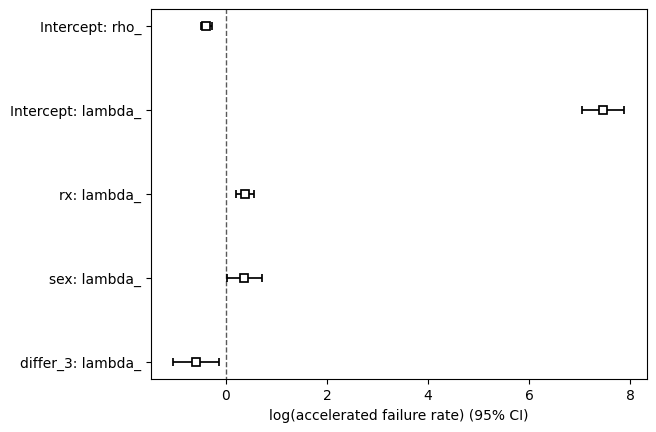

In [37]:
wb_aft.plot()

Model pozwala przewidywać funkcje survival dla poszczególnych rekordów. Poniżej przedstawiona jest przykładowa funkcja dla pierwszego rekordu

In [38]:
colon.iloc[0:1]

,time,status,rx,sex,age,obstruct,adhere,differ_2,differ_3
0,8,1,3,0,32,0,0,False,True


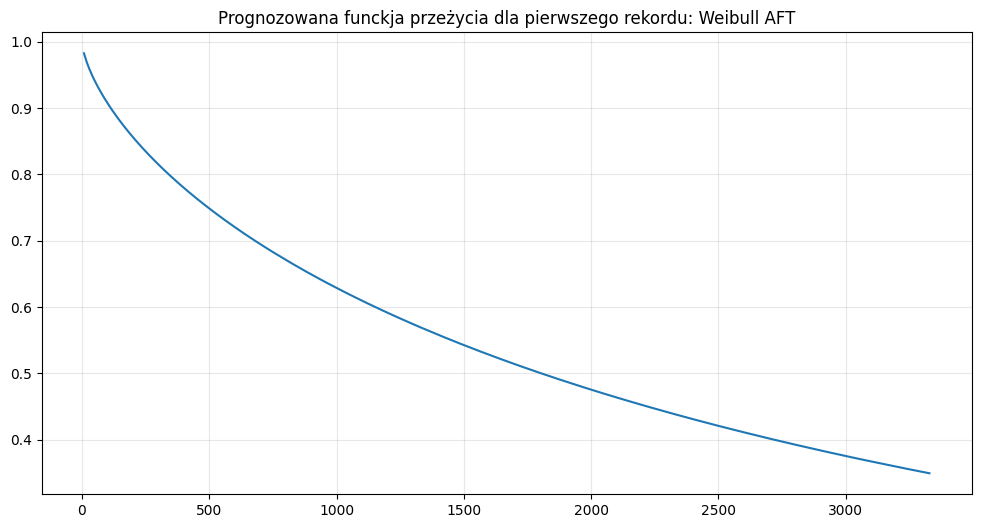

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(wb_aft.predict_survival_function(colon.iloc[0:1]))
plt.grid(alpha = 0.3)
plt.title('Prognozowana funckja przeżycia dla pierwszego rekordu: Weibull AFT')
plt.show()

### Lon-normal AFT

In [40]:
from lifelines import LogNormalAFTFitter

ln_aft = LogNormalAFTFitter()
ln_aft.fit(colon, duration_col='time', event_col='status')
ln_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2404.26
         time fit was run = 2025-05-21 02:09:58 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    adhere    -0.30      0.74      0.25           -0.80            0.19                0.45                1.21
       age        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
       differ_2  -0.32      0.73      0.30           -0.91            0.28                0.40                1.32
       differ_3  -1.07      0.34      0.36           -1.77           -0.36                0.17                0.70
       obstruct  -0.40      0.67      0.23           -0.85            0.05                0.43                1.06
       rx         0.40      1.49      0.09            0.22            0.58                1.24                1.79
       sex        0.40      1.49      0.18            0.04            0.76                1.04                2.14
       Intercept  6.54    694.92      0.57            5.42            7.66              226.69             2130.28
sigma_ Intercept  0.67      1.95      0.05            0.57            0.76                1.77                2.14

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    adhere       0.00 -1.20   0.23      2.13
       age          0.00  1.56   0.12      3.08
       differ_2     0.00 -1.05   0.29      1.76
       differ_3     0.00 -2.95 <0.005      8.30
       obstruct     0.00 -1.72   0.08      3.56
       rx           0.00  4.29 <0.005     15.78
       sex          0.00  2.18   0.03      5.08
       Intercept    0.00 11.45 <0.005     98.41
sigma_ Intercept    0.00 13.83 <0.005    142.04
---
Concordance = 0.61
AIC = 4826.51
log-likelihood ratio test = 39.04 on 7 df
-log2(p) of ll-ratio test = 18.99

In [41]:
ln_aft = LogNormalAFTFitter()
ln_aft.fit(colon[['time', 'status', 'differ_3', 'rx', 'sex']], duration_col='time', event_col='status')
ln_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2408.41
         time fit was run = 2025-05-21 02:09:59 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    differ_3  -0.82      0.44      0.24           -1.30           -0.34                0.27                0.71
       rx         0.40      1.49      0.09            0.22            0.58                1.25                1.79
       sex        0.41      1.50      0.18            0.05            0.77                1.05                2.16
       Intercept  6.86    953.28      0.23            6.41            7.31              607.42             1496.05
sigma_ Intercept  0.67      1.96      0.05            0.58            0.77                1.79                2.16

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    differ_3     0.00 -3.37 <0.005     10.39
       rx           0.00  4.32 <0.005     15.97
       sex          0.00  2.21   0.03      5.20
       Intercept    0.00 29.83 <0.005    647.23
sigma_ Intercept    0.00 13.98 <0.005    145.07
---
Concordance = 0.60
AIC = 4826.82
log-likelihood ratio test = 30.73 on 3 df
-log2(p) of ll-ratio test = 19.97

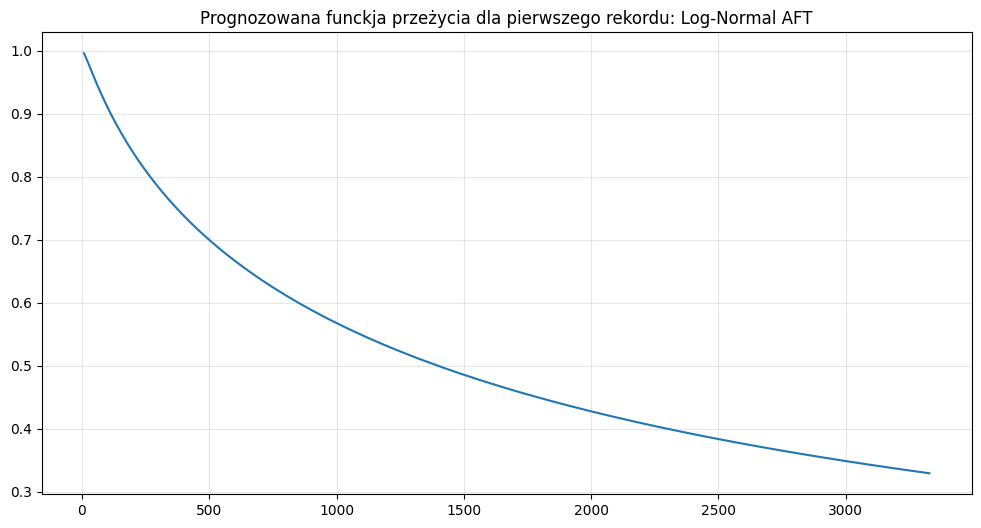

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(ln_aft.predict_survival_function(colon.iloc[0:1]))
plt.grid(alpha = 0.3)
plt.title('Prognozowana funckja przeżycia dla pierwszego rekordu: Log-Normal AFT')
plt.show()

### Lon-logistic AFT

In [43]:
from lifelines import LogLogisticAFTFitter

ll_aft = LogLogisticAFTFitter()
ll_aft.fit(colon[['time', 'status', 'differ_3', 'rx', 'sex']], duration_col='time', event_col='status')
ll_aft.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2418.81
         time fit was run = 2025-05-21 02:10:00 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
alpha_ differ_3  -0.80      0.45      0.25           -1.30           -0.31                0.27                0.74
       rx         0.42      1.53      0.09            0.24            0.61                1.27                1.84
       sex        0.45      1.57      0.19            0.08            0.82                1.08                2.26
       Intercept  6.74    845.91      0.23            6.29            7.19              537.88             1330.35
beta_  Intercept -0.16      0.85      0.05           -0.26           -0.06                0.77                0.94

                  cmp to     z      p  -log2(p)
param  covariate                               
alpha_ differ_3     0.00 -3.16 <0.005      9.32
       rx           0.00  4.47 <0.005     16.94
       sex          0.00  2.39   0.02      5.91
       Intercept    0.00 29.18 <0.005    619.29
beta_  Intercept    0.00 -3.11 <0.005      9.04
---
Concordance = 0.60
AIC = 4847.61
log-likelihood ratio test = 32.04 on 3 df
-log2(p) of ll-ratio test = 20.89

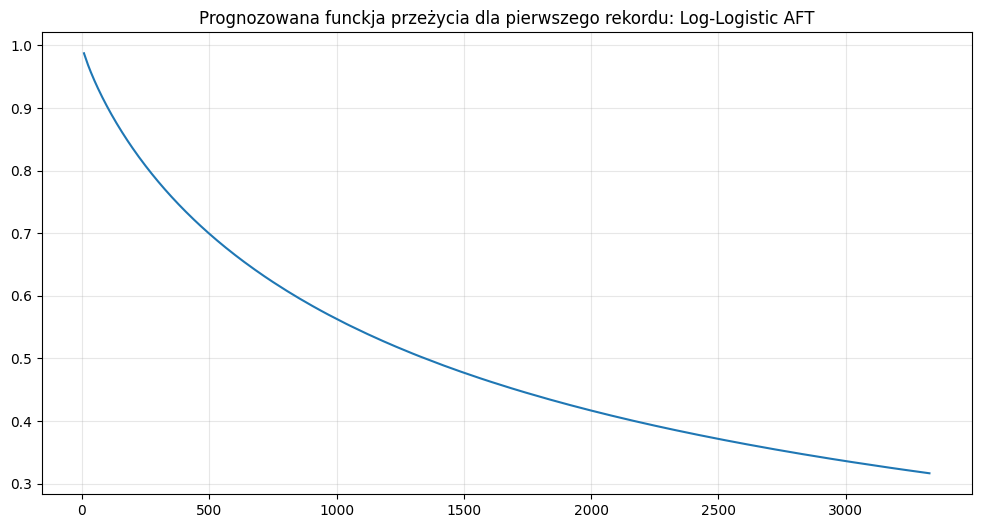

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(ll_aft.predict_survival_function(colon.iloc[0:1]))
plt.grid(alpha = 0.3)
plt.title('Prognozowana funckja przeżycia dla pierwszego rekordu: Log-Logistic AFT')
plt.show()

### Porównanie modeli

Porównanie prognozowanych krzywych przeżycia

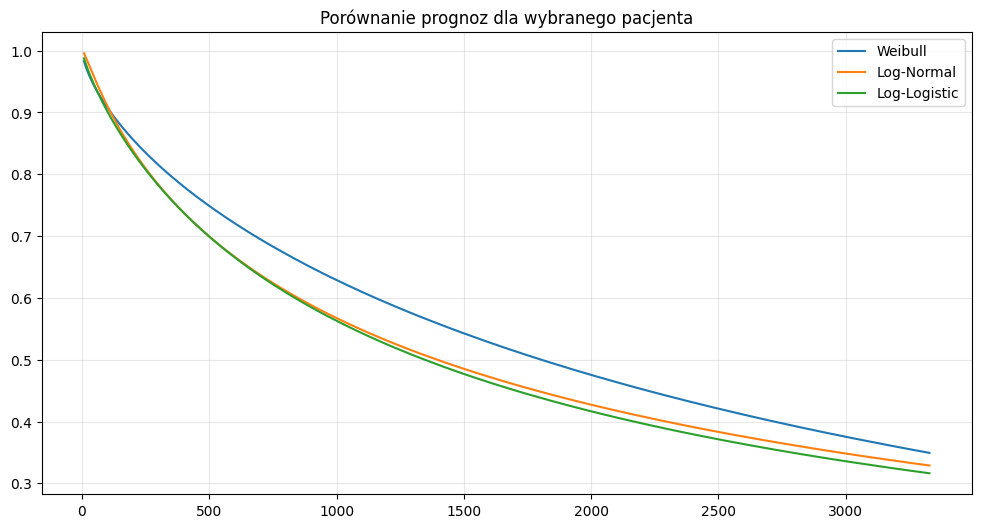

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(wb_aft.predict_survival_function(colon.iloc[0:1]), label = 'Weibull')
plt.plot(ln_aft.predict_survival_function(colon.iloc[0:1]), label = 'Log-Normal')
plt.plot(ll_aft.predict_survival_function(colon.iloc[0:1]), label = 'Log-Logistic')
plt.grid(alpha = 0.3)
plt.title('Porównanie prognoz dla wybranego pacjenta')
plt.legend()
plt.show()

Porównanie wartości funkcji największej wiarygodności

In [46]:
print(f"Weibull LL: {wb_aft.log_likelihood_}")
print(f"Log-Normal LL: {ln_aft.log_likelihood_}")
print(f"Log-Logistic LL: {ll_aft.log_likelihood_}")

Weibull LL: -2435.9850490661183
Log-Normal LL: -2408.411937701597
Log-Logistic LL: -2418.8060536205085


## Analiza semiparametryczna - model parametrycznych hazardów Coxa

In [47]:
# Cox PH model
cph = lfl.CoxPHFitter()
cph.fit(colon, duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1642.19
         time fit was run = 2025-05-21 02:10:07 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
rx        -0.25      0.78      0.06           -0.37           -0.13                0.69                0.88
sex       -0.26      0.77      0.12           -0.50           -0.02                0.61                0.98
age       -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
obstruct   0.25      1.28      0.15           -0.05            0.54                0.96                1.72
adhere     0.23      1.25      0.16           -0.09            0.54                0.92                1.72
differ_2   0.23      1.26      0.21           -0.18            0.64                0.83                1.90
differ_3   0.60      1.83      0.25            0.12            1.08                1.13                2.96

           cmp to     z      p  -log2(p)
covariate                               
rx           0.00 -4.03 <0.005     14.13
sex          0.00 -2.16   0.03      5.01
age          0.00 -1.78   0.08      3.72
obstruct     0.00  1.66   0.10      3.36
adhere       0.00  1.41   0.16      2.66
differ_2     0.00  1.10   0.27      1.88
differ_3     0.00  2.45   0.01      6.12
---
Concordance = 0.61
Partial AIC = 3298.38
log-likelihood ratio test = 35.38 on 7 df
-log2(p) of ll-ratio test = 16.69

In [48]:
cph = lfl.CoxPHFitter()
cph.fit(colon[['time', 'status', 'sex', 'rx', 'differ_3']], duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1646.72
         time fit was run = 2025-05-21 02:10:07 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
sex       -0.25      0.78      0.12           -0.49           -0.02                0.61                0.98
rx        -0.25      0.78      0.06           -0.38           -0.13                0.69                0.87
differ_3   0.43      1.53      0.16            0.12            0.73                1.13                2.08

           cmp to     z      p  -log2(p)
covariate                               
sex          0.00 -2.09   0.04      4.79
rx           0.00 -4.14 <0.005     14.78
differ_3     0.00  2.71   0.01      7.23
---
Concordance = 0.60
Partial AIC = 3299.43
log-likelihood ratio test = 26.33 on 3 df
-log2(p) of ll-ratio test = 16.91


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
         test_name = proportional_hazard_test

---
               test_statistic      p  -log2(p)
differ_3 km             13.88 <0.005     12.33
         rank           13.96 <0.005     12.39
rx       km              1.17   0.28      1.83
         rank            1.18   0.28      1.85
sex      km              0.81   0.37      1.44
         rank            0.79   0.37      1.42



1. Variable 'differ_3' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['differ_3', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.3736)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3682)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2776)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2803)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0002)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0002)'>]]

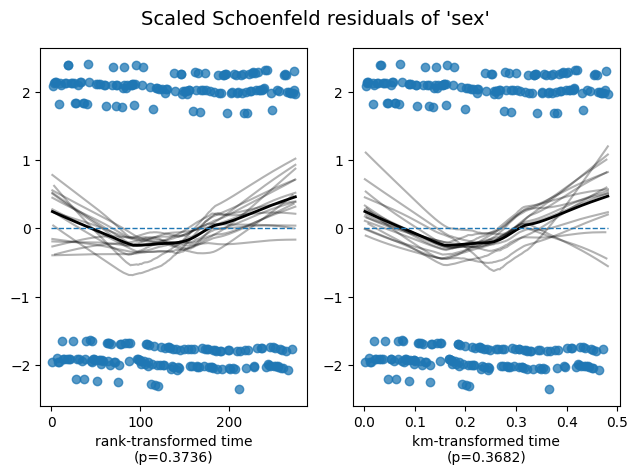

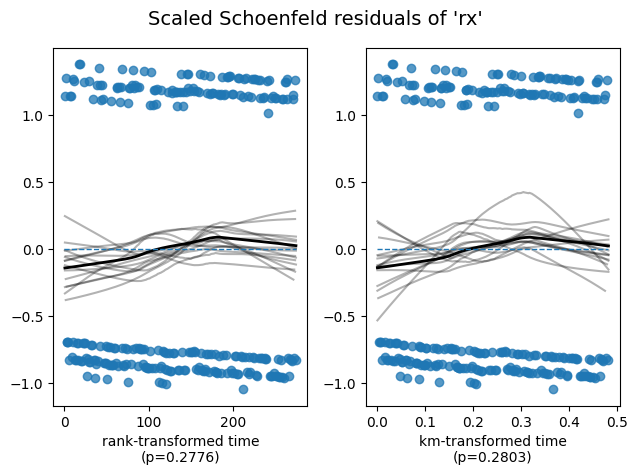

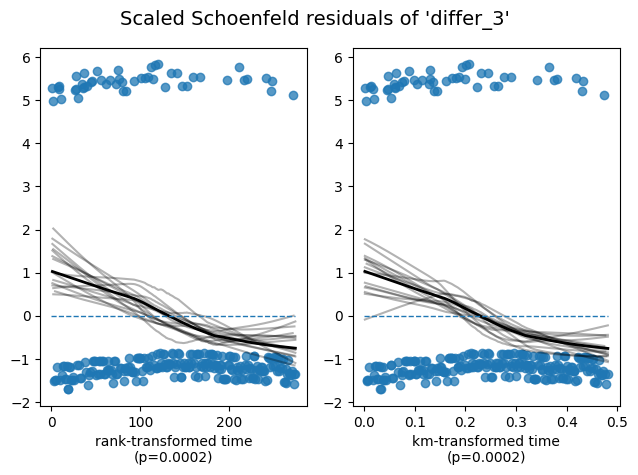

In [49]:
cph.check_assumptions(colon[['time', 'status', 'sex', 'rx', 'differ_3']], p_value_threshold=0.05, show_plots= True)

Założenie proporcjonalnych hazardów nie jest spełnione dla zmiennej differ_3. Z tego powodu wprowadzamy do modelu zależność tej zmiennej od czasu.

In [50]:
colon_tv = colon.copy()
colon_tv['differ_3*time'] = colon_tv['time']*colon_tv['differ_3']

In [51]:
cph = lfl.CoxPHFitter()
cph.fit(colon_tv[['time', 'status', 'sex', 'rx', 'differ_3*time']], duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1638.41
         time fit was run = 2025-05-21 02:10:14 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
sex           -0.21      0.81      0.12           -0.45            0.02                0.64                1.02
rx            -0.24      0.79      0.06           -0.36           -0.12                0.70                0.89
differ_3*time -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

               cmp to     z      p  -log2(p)
covariate                                   
sex              0.00 -1.76   0.08      3.69
rx               0.00 -3.85 <0.005     13.03
differ_3*time    0.00 -3.77 <0.005     12.58
---
Concordance = 0.59
Partial AIC = 3282.82
log-likelihood ratio test = 42.94 on 3 df
-log2(p) of ll-ratio test = 28.56


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5105)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5037)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3583)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3612)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9678)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9676)'>]]

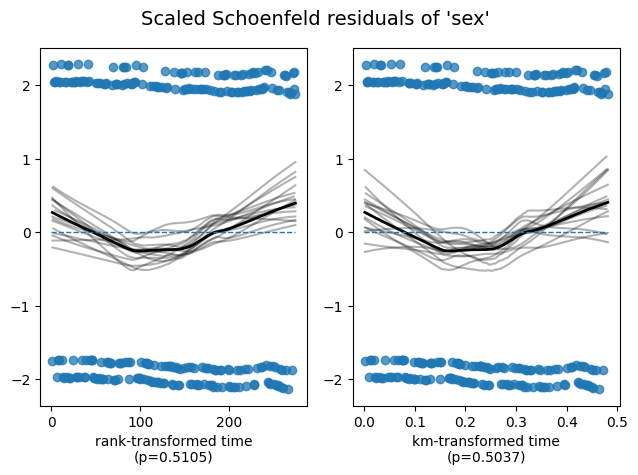

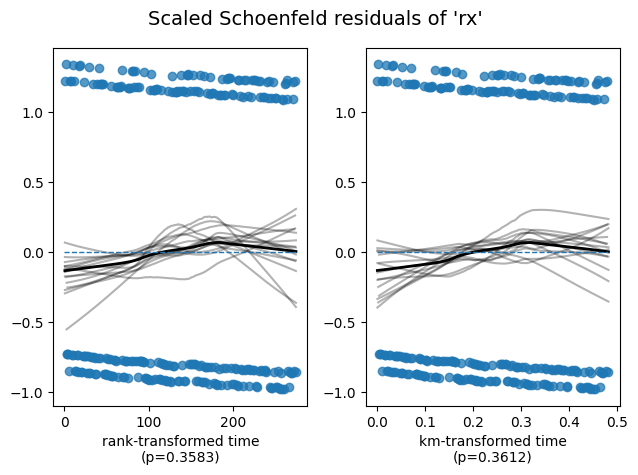

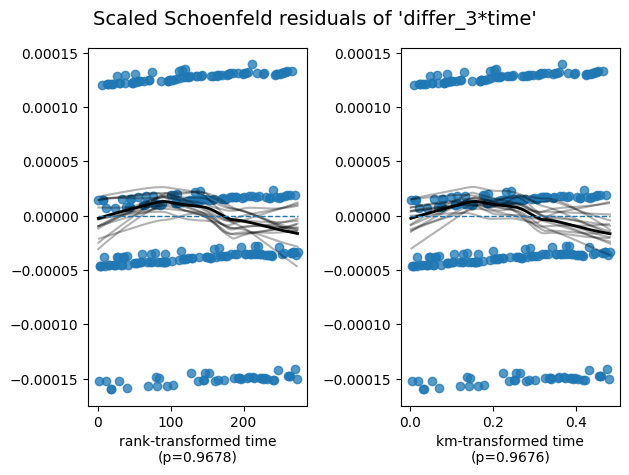

In [52]:
cph.check_assumptions(colon[['time', 'status', 'sex', 'rx', 'differ_3']], p_value_threshold=0.05, show_plots= True)